# Predicting and Preventing Injury Using Acute to Chronic Workload Ratio (ACWR)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime

#turns off warning for chained assignment as we are overwriting references to original dataframe
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 30)

# load data file
df = pd.read_csv("../Data/Soccer.csv", parse_dates=["Date"])
df

,Player.Name,Period.Name,Position.Name,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,Date
0,12,Session,D,276.85373,15.33448,205,0,170.91685,2019-08-06
1,89,Session,GK,238.00543,14.04880,205,101,174.15563,2019-08-06
2,63,Session,F,231.84551,14.36184,206,0,179.25900,2019-08-06
3,15,Session,D,355.02606,18.78379,216,0,177.66543,2019-08-06
4,44,Session,D,318.82076,17.41175,218,0,180.77740,2019-08-06
...,...,...,...,...,...,...,...,...,...
9549,100,2ND HALF,D,353.77399,8.55915,127,0,127.00000,2019-11-24
9550,21,2ND HALF,D,532.78271,10.43649,129,129,129.00000,2019-11-24
9551,43,2ND HALF,M,486.08109,12.38176,217,0,170.76598,2019-11-24
9552,91,2ND HALF,F,226.33687,8.09753,128,128,128.00000,2019-11-24


## Exploratory Data Analysis

In [2]:
#  make a new dataset (or dataframe) using only the “session” periods from the season
ses = df[df["Period.Name"] == 'Session']

In [3]:
# create a variable for the “session duration”
ses["Session.Duration"] = ses["Total.Player.Load"]/ses["Player.Load.Per.Minute"]

In [4]:
# rank the team players by their cumulative playerload across the entire season
ses.groupby(["Player.Name", "Position.Name"])["Total.Player.Load"].sum().sort_values(ascending=False)

Player.Name  Position.Name
43           M                61807.06587
62           F                55455.84319
4            M                54531.06541
21           D                52448.84502
44           D                45528.61318
66           M                44035.16557
100          D                43435.17877
39           D                42966.83272
12           D                42594.47149
52           D                41966.27363
35           F                39743.46043
86           M                38332.92067
10           D                35760.14918
63           F                34497.65386
15           D                32792.41598
18           D                28582.29879
97           F                28388.64588
49           F                28331.33281
91           F                27545.34959
48           M                26757.18323
34           M                26380.69503
89           GK               25943.30417
9            F                24544.28285
95     

In [5]:
# determine the 10 highest sessions for player load 
ses.sort_values(by="Total.Player.Load", ascending=False).head(10)

,Player.Name,Period.Name,Position.Name,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,Date,Session.Duration
8482,43,Session,M,1755.08710,11.85336,218,0,162.17158,2019-11-08,148.066633
9338,43,Session,M,1701.65860,12.84722,229,0,168.91000,2019-11-22,132.453449
4874,62,Session,F,1695.69403,12.77450,210,0,147.47929,2019-09-19,132.740540
4883,43,Session,M,1672.69440,13.69880,217,0,165.77741,2019-09-19,122.105177
4489,43,Session,M,1649.17551,11.38274,219,0,164.28843,2019-09-13,144.883878
5697,4,Session,M,1641.06146,10.75199,205,94,170.58953,2019-09-29,152.628626
3536,43,Session,M,1635.75719,9.69604,210,0,150.83079,2019-09-01,168.703635
5703,43,Session,M,1617.42587,11.99220,225,0,166.82273,2019-09-29,134.873157
8471,62,Session,F,1576.30459,10.64591,215,0,159.91105,2019-11-08,148.066684
5937,4,Session,M,1565.28558,9.92887,199,0,162.30780,2019-10-03,157.649922


## Visualize Daily ACRW and Player Load of Player with Highest Cumulative Player Load

In [6]:
#  Remove the two players with the lowest cumulative player load 
ses = ses[(ses["Player.Name"] != 98) & (ses["Player.Name"] != 62) & (ses["Position.Name"] != 'GK')]
ses = ses.sort_values(by=["Player.Name", "Date"])
ses = ses.set_index('Date')

In [7]:
# create data for ACRW of player with highest cumulative player load
ses_43 = ses[ses["Player.Name"]==43][["Total.Player.Load", "Session.Duration"]]

# create consecutive days that don't exist to accurately define date period
ses_43 = ses_43.resample('D').sum() 

# fill in newly created dates with 0
ses_43 = ses_43.fillna(0)

# create new columns to calculate ACRW
ses_43["Acute_PL"] = (ses_43["Total.Player.Load"].rolling('7D', 7).sum())/7
ses_43["Chronic_PL"] = (ses_43["Total.Player.Load"].rolling('21D', 21).sum())/21
ses_43["Acute:Chronic"] = ses_43["Acute_PL"]/ses_43["Chronic_PL"]
ses_43.head()

,Total.Player.Load,Session.Duration,Acute_PL,Chronic_PL,Acute:Chronic
Date,,,,,
2019-08-06,1384.29407,148.599858,NaN,NaN,NaN
2019-08-07,1231.07260,192.827240,NaN,NaN,NaN
2019-08-08,0.00000,0.000000,NaN,NaN,NaN
2019-08-09,1258.91826,163.980353,NaN,NaN,NaN
2019-08-10,614.87480,86.198288,NaN,NaN,NaN


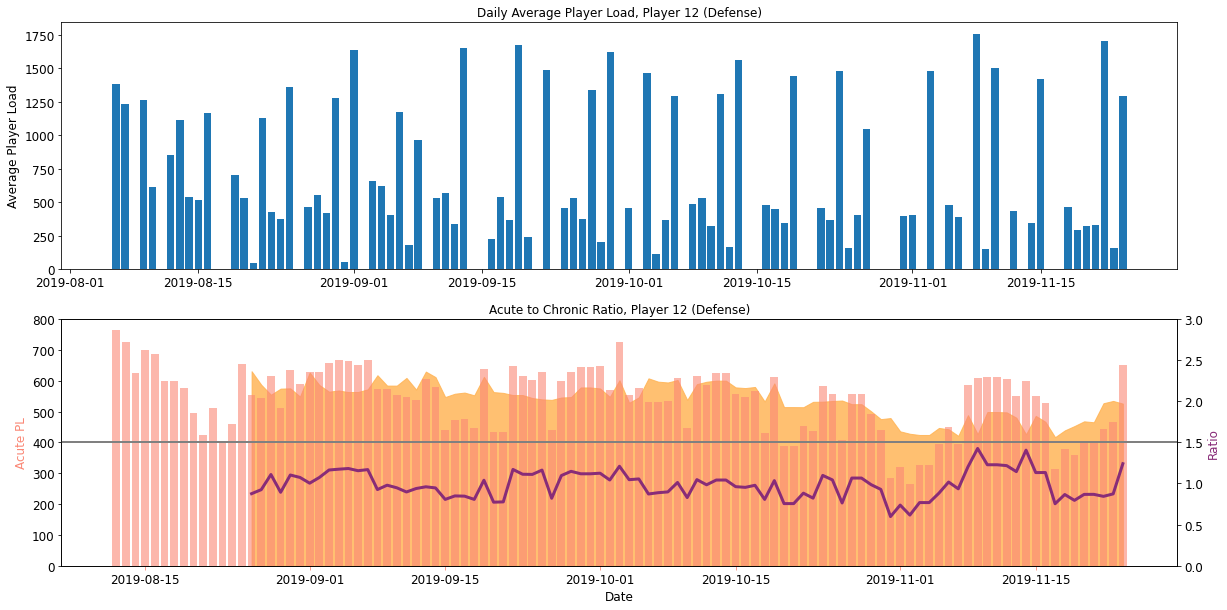

In [8]:
"""
Create graphs visualizing daily player load for player with highest cumulative player load, and corresponding
acute-to-chronic workload ratio.

Key:
1. Acute player load (light pink bars)
2. Chronic player load (shaded orange)
3. Acute to chronic workload ratio (dark purple line)
4. "Normal" threshold (gray line)
"""

fig, ax = plt.subplots(2,figsize=(20, 10))

ax[0].bar(ses_43.index, ses_43["Total.Player.Load"])
ax[0].tick_params(axis='x', labelsize=12,)
ax[0].set_ylabel('Average Player Load', fontsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_title("Daily Average Player Load, Player 12 (Defense)", fontsize=12)

color='#FA8775'
ax[1].set_xlabel("Date", fontsize=12)
ax[1].tick_params(axis='x', labelsize=12, color=color)
ax[1].set_ylabel('Acute PL', color=color, fontsize=12)
ax[1].bar(ses_43.index, ses_43["Acute_PL"], color=color, alpha=0.6)
ax[1].tick_params(axis='y', labelsize=12)
color='#FFB14E'
ax[1].fill_between(ses_43.index, ses_43["Chronic_PL"], color=color, alpha=0.8)
ax[1] = plt.gca()
ax[1].set_title("Acute to Chronic Ratio, Player 12 (Defense)", fontsize=12)
ax1 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis

color='#882C78'
ax1.set_ylabel('Ratio', fontsize=12, color=color)  
ax1.plot(ses_43.index, ses_43["Acute:Chronic"], color=color, linewidth=3.0)
ax1.tick_params(axis='y', labelsize=12)
ax1 = plt.gca()

ax1.set_ylim([0,3.0])

ax1.axhline(y=1.5,c="gray",linewidth=2,zorder=0)

Player 43, who boasts the highest cumulative player load and highest singular player load within a session, stays below the acute-to-chronic workload ratio of 1.5, indicating the player is not at significant risk for injury.

## Visualize Daily ACRW and Player Load of Player with Lowest Cumulative Player Load

In [9]:
# create data for ACRW of player with lowest cumulative player load
ses_95 = ses[ses["Player.Name"]==95][["Total.Player.Load", "Session.Duration"]]

# create consecutive days that don't exist to accurately define date period
ses_95 = ses_95.resample('D').sum() 

# fill in newly created dates with 0
ses_95 = ses_95.fillna(0)

# create new columns to calculate ACRW
ses_95["Acute_PL"] = (ses_95["Total.Player.Load"].rolling('7D', 7).sum())/7
ses_95["Chronic_PL"] = (ses_95["Total.Player.Load"].rolling('21D', 21).sum())/21
ses_95["Acute:Chronic"] = ses_95["Acute_PL"]/ses_95["Chronic_PL"]
ses_95.head()

,Total.Player.Load,Session.Duration,Acute_PL,Chronic_PL,Acute:Chronic
Date,,,,,
2019-08-06,1266.55664,148.276174,NaN,NaN,NaN
2019-08-07,995.73521,192.827229,NaN,NaN,NaN
2019-08-08,0.00000,0.000000,NaN,NaN,NaN
2019-08-09,1191.99821,175.575100,NaN,NaN,NaN
2019-08-10,579.45148,93.327151,NaN,NaN,NaN


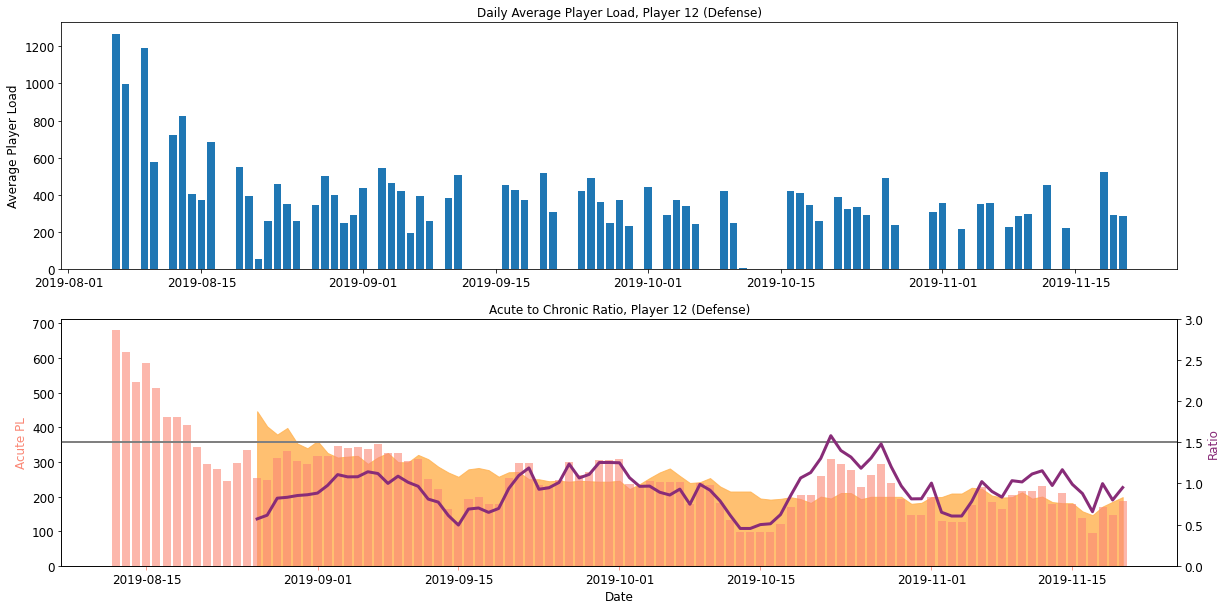

In [10]:
fig, ax = plt.subplots(2,figsize=(20, 10))

ax[0].bar(ses_95.index, ses_95["Total.Player.Load"])
ax[0].tick_params(axis='x', labelsize=12,)
ax[0].set_ylabel('Average Player Load', fontsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_title("Daily Average Player Load, Player 12 (Defense)", fontsize=12)

color='#FA8775'
ax[1].set_xlabel("Date", fontsize=12)
ax[1].tick_params(axis='x', labelsize=12, color=color)
ax[1].set_ylabel('Acute PL', color=color, fontsize=12)
ax[1].bar(ses_95.index, ses_95["Acute_PL"], color=color, alpha=0.6)
ax[1].tick_params(axis='y', labelsize=12)
color='#FFB14E'
ax[1].fill_between(ses_95.index, ses_95["Chronic_PL"], color=color, alpha=0.8)
ax[1] = plt.gca()
ax[1].set_title("Acute to Chronic Ratio, Player 12 (Defense)", fontsize=12)
ax1 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis

color='#882C78'
ax1.set_ylabel('Ratio', fontsize=12, color=color)  
ax1.plot(ses_95.index, ses_95["Acute:Chronic"], color=color, linewidth=3.0)
ax1.tick_params(axis='y', labelsize=12)
ax1 = plt.gca()

ax1.set_ylim([0,3.0])

ax1.axhline(y=1.5,c="gray",linewidth=2,zorder=0)

Player 95, who has the lowest cumulative player load, stays peaks above the acute-to-chronic workload ratio of 1.5 multiple times, indicating significant risk for injury while training.

## Visualize Average Daily ACRW and Player Load of Entire Team

In [11]:
df_all = ses.groupby("Date").sum()
df_all = df_all.resample('D').sum()
df_all = df_all.fillna(0)

df_all["Acute_PL"] = (df_all["Total.Player.Load"].rolling('7D', 7).sum())/7
df_all["Chronic_PL"] = (df_all["Total.Player.Load"].rolling('21D', 21).sum())/21
df_all["Acute:Chronic"] = df_all["Acute_PL"]/df_all["Chronic_PL"]
df_all.head(10)

,Player.Name,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,Session.Duration,Acute_PL,Chronic_PL,Acute:Chronic
Date,,,,,,,,,,
2019-08-06,2696,21457.62648,578.47427,9810,1464,7896.95444,2718.800956,NaN,NaN,NaN
2019-08-07,2367,21576.70582,320.09410,9141,1221,6727.04942,3960.461380,NaN,NaN,NaN
2019-08-08,0,0.00000,0.00000,0,0,0.00000,0.000000,NaN,NaN,NaN
2019-08-09,1935,19715.55092,255.97996,7105,1023,5253.16905,3173.360914,NaN,NaN,NaN
2019-08-10,1113,8707.56628,113.13464,3862,693,2801.49209,1653.143806,NaN,NaN,NaN
2019-08-11,0,0.00000,0.00000,0,0,0.00000,0.000000,NaN,NaN,NaN
2019-08-12,931,13495.42490,135.41093,3485,411,2492.89425,1986.196151,12136.124914,NaN,NaN
2019-08-13,1935,16179.74976,196.51043,7326,327,5058.30292,3311.968716,11382.142526,NaN,NaN
2019-08-14,931,9114.80171,112.96797,3549,303,2456.94682,1613.696645,9601.870510,NaN,NaN


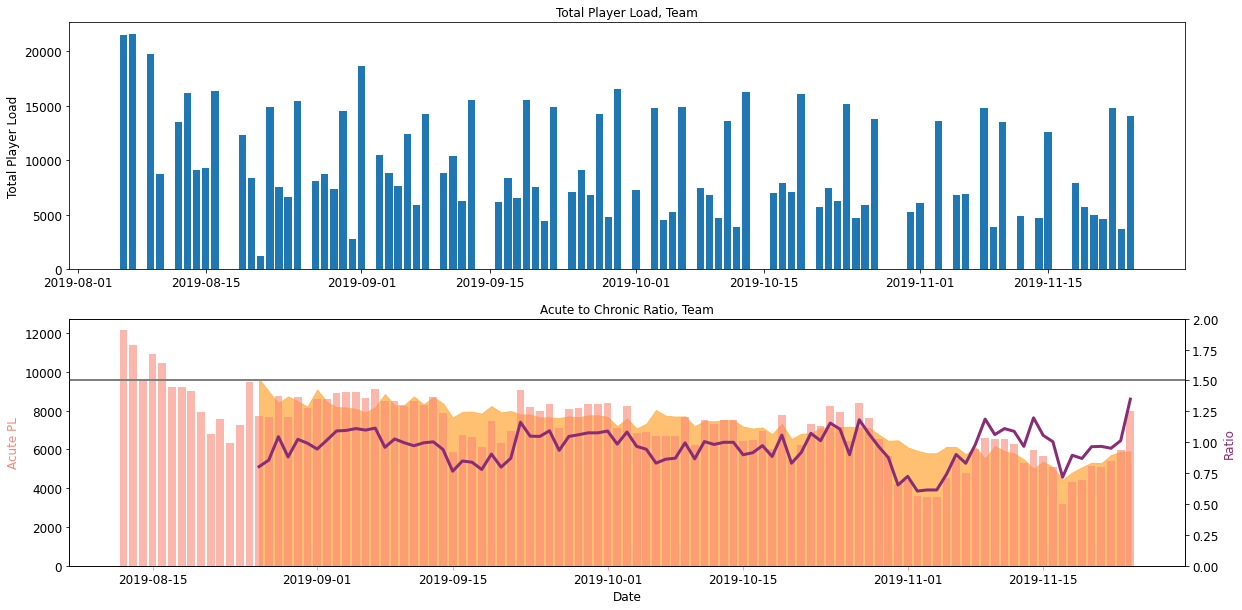

In [12]:
fig, axs = plt.subplots(2,figsize=(20, 10))

axs[0].bar(df_all.index, df_all["Total.Player.Load"])
#axs[0].set_xlabel("Date", fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].set_ylabel('Total Player Load', fontsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_title("Total Player Load, Team", fontsize=12)

color='#FA8775'
axs[1].set_xlabel("Date", fontsize=12)
axs[1].tick_params(axis='x', labelsize=12, color=color)
axs[1].set_ylabel('Acute PL', color=color, fontsize=12)
axs[1].bar(df_all.index, df_all["Acute_PL"], color=color, alpha=0.6)
axs[1].tick_params(axis='y', labelsize=12)

color='#FFB14E'
axs[1].fill_between(df_all.index, df_all["Chronic_PL"], color=color, alpha=0.8)
axs[1] = plt.gca()
axs[1].set_title("Acute to Chronic Ratio, Team", fontsize=12)
axs1 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

color='#882C78'
axs1.set_ylabel('Ratio', fontsize=12, color=color)  # we already handled the x-label with ax1
axs1.plot(df_all.index, df_all["Acute:Chronic"], color=color, linewidth=3.0)
axs1.tick_params(axis='y', labelsize=12)
axs1 = plt.gca()

# To see how the acute to chronic workload ratio drops over the first 28 days, 
# comment out this line by adding a '#' in front of the line
axs1.set_ylim([0,2.0])

axs1.axhline(y=1.5,c="gray",linewidth=2,zorder=0)

On average, the team remains below the 1.5 threshold for ACRW, indicating they are not generally at significant risk for injury.